# pems-bay.h5

In [1]:
import h5py
import pickle
import folium
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
with h5py.File('data/PEMS-BAY/pems-bay.h5', 'r') as file:

    axis0 = file['speed']['axis0'][:]               # Идентификаторы датчиков
    block0_items = file['speed']['block0_items'][:] # Идентификаторы датчиков
    axis1 = file['speed']['axis1'][:]               # Метки времени
    timestamps = pd.to_datetime(axis1)              # Преобразование меток времени в формат datetime
    speed_data = file['speed']['block0_values'][:]  # Данные замеров скорости

perms_bay = pd.DataFrame(speed_data, index=timestamps, columns=axis0)


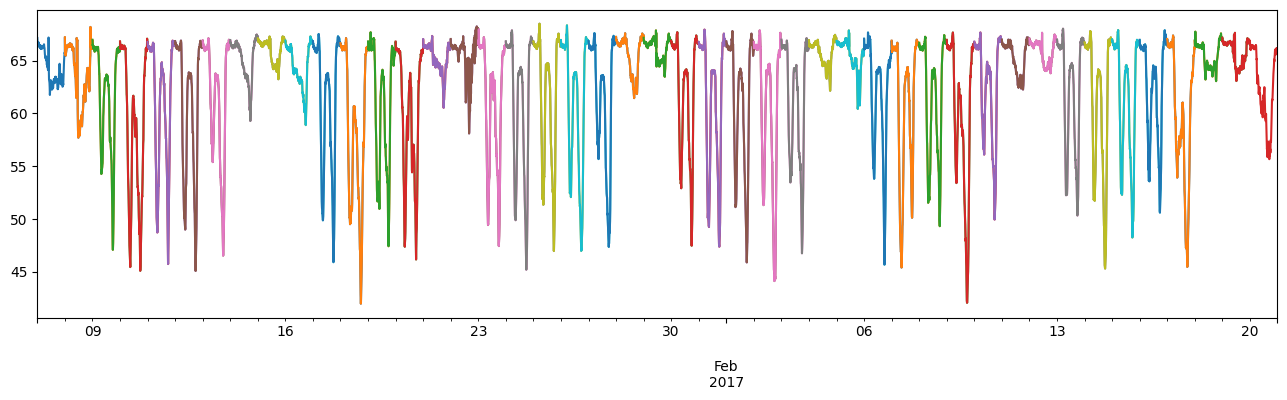

In [59]:
slice = 24 * 60 // 5

# for i in range(7):
#     perms_bay.mean(axis=1)[slice*(i):slice*(i+1)].plot(figsize=(16, 4))

for i in range(6, 50):
    perms_bay.mean(axis=1)[slice*(i):slice*(i+2)].plot(figsize=(16, 4))

In [3]:
# Открытие .pkl файла
with open('data/PEMS-BAY/adj_mx_bay.pkl', 'rb') as file:
    data = pickle.load(file, encoding='bytes')

In [4]:
node_ids = [x.decode('utf-8') for x in data[0]]                     # Получаем список id узлов из data[0]
adj_matrix = data[2]                                                # Получаем матрицу смежности из data[2]
adj_df = pd.DataFrame(adj_matrix, index=node_ids, columns=node_ids) # Создание DataFrame с использованием id узлов как индексов и названий колонок

In [5]:
distances_df = pd.read_csv('data/PEMS-BAY/distances_bay_2017.csv', header=None)
locations_df = pd.read_csv('data/PEMS-BAY/graph_sensor_locations_bay.csv', header=None)

In [11]:
distances_df

,0,1,2
0,400001,400001,0.0
1,400017,400017,0.0
2,400030,400030,0.0
3,400030,400045,5108.4
4,400030,400065,7401.1
...,...,...,...
8353,414694,405701,1016.7
8354,414694,407710,2290.3
8355,414694,408907,8610.4
8356,414694,408911,9119.3


In [ ]:
# Создание графа
G = nx.Graph()

# Добавление узлов с координатами
for _, row in locations_df.iterrows():
    node_id = row[0]
    x, y = row[1], row[2]
    G.add_node(str(int(node_id)), pos=(x, y))

# Добавление рёбер на основе матрицы смежности
for node1 in adj_df.index:
    for node2 in adj_df.columns:
        weight = adj_df.loc[node1, node2]
        if weight != 0 and node1 != node2:  # Добавляем ребро только если вес не равен 0
            G.add_edge(node1, node2, weight=weight)

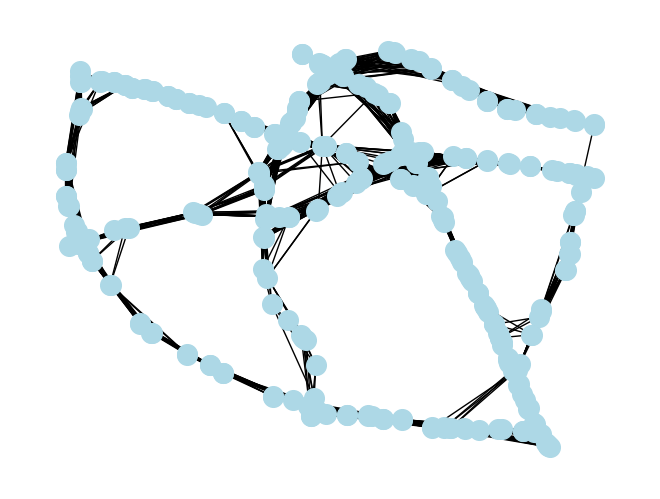

In [31]:
# Визуализация графа с использованием координат
pos = nx.get_node_attributes(G, 'pos')  # получаем координаты
nx.draw(G, pos, with_labels=False, node_size=200, node_color='lightblue', font_size=8)
plt.show()

In [32]:
# Создаем карту Folium, центрируем её на одном из узлов
m = folium.Map(location=[37.359087, -121.906538], zoom_start=13)

# Добавляем узлы на карту
for node, data in G.nodes(data=True):
    folium.Circle(location=[data['pos'][0], data['pos'][1]], popup=str(node)).add_to(m)

# Добавляем рёбра на карту
for edge in G.edges(data=True):
    node1 = edge[0]
    node2 = edge[1]
    
    # Координаты двух узлов
    loc1 = G.nodes[node1]['pos']
    loc2 = G.nodes[node2]['pos']
    
    # Рисуем линию между узлами
    folium.PolyLine(locations=[(loc1[0], loc1[1]), (loc2[0], loc2[1])], color='gray', weight=2.5, opacity=0.7).add_to(m)

# Отображаем карту
# m.save('graph_map.html')
m

# METR-LA

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import networkx as nx
import folium
import ast
import h5py
import pickle

In [2]:
# Загрузка данных
edges = pd.read_csv('data/METR-LA/METR_LA.rel')  # Укажите путь к файлу edges
nodes = pd.read_csv('data/METR-LA/METR_LA.geo')  # Укажите путь к файлу nodes
data_df = pd.read_csv('data/METR-LA/METR_LA.dyna')

# Преобразование строки координат в список
nodes['coordinates'] = nodes['coordinates'].apply(ast.literal_eval)

# Открытие .pkl файла
with open('data/METR-LA/adj_mx.pkl', 'rb') as file:
    data = pickle.load(file, encoding='bytes')

In [3]:
node_ids = [str(x.decode('utf-8')) for x in data[0]]                # Получаем список id узлов из data[0]
adj_matrix = data[2]                                                # Получаем матрицу смежности из data[2]
adj_df = pd.DataFrame(adj_matrix, index=node_ids, columns=node_ids) # Создание DataFrame с использованием id узлов как индексов и названий колонок

In [4]:
data_df = data_df.merge(nodes, left_on='entity_id', right_on='geo_id')

In [ ]:
data_df['geometry'] = data_df['coordinates'].apply(lambda x: Point(x[0], x[1])) # Создание колонки 'geometry' с объектами типа Point
geo_data_df = gpd.GeoDataFrame(data_df, geometry='geometry') # Преобразование DataFrame в GeoDataFrame
geo_data_df.set_crs(epsg=4326, inplace=True) # Установка CRS (например, WGS84 - EPSG:4326)

geo_data_df.drop_duplicates(subset=['entity_id']).explore()

In [5]:
# Создание графа
G = nx.Graph()

# Добавление узлов с координатами
for _, row in nodes.iterrows():
    node_id = str(int(row['geo_id']))
    pos = tuple(row['coordinates'])  # Преобразование координат в кортеж (долгота, широта)
    G.add_node(node_id, pos=pos)

# Добавление рёбер на основе матрицы смежности
for node1 in adj_df.index:
    for node2 in adj_df.columns:
        weight = adj_df.loc[node1, node2]
        if weight != 0 and node1 != node2:  # Добавляем ребро только если вес не равен 0
            G.add_edge(node1, node2, weight=weight)

In [ ]:
# Инициализация карты Folium
# Центруем на первой координате узлов
center_lat, center_lon = nodes['coordinates'][0][1], nodes['coordinates'][0][0]
m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# Добавление ребер как линий
for u, v, data in G.edges(data=True):
    origin_pos = G.nodes[u]['pos']
    destination_pos = G.nodes[v]['pos']
    folium.PolyLine(
        locations=[[origin_pos[1], origin_pos[0]], [destination_pos[1], destination_pos[0]]],  # Переворот на (широта, долгота)
        color='gray',
        weight=1,
        opacity=0.7
    ).add_to(m)
    
# Добавление узлов как кругов
for node, data in G.nodes(data=True):
    folium.Circle(
        location=[data['pos'][1], data['pos'][0]],  # Переворот на (широта, долгота)
        radius=30,  # Радиус круга в метрах
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
    ).add_to(m)


# Отображение карты
m

In [6]:
from community import community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx

E:\Temp\ipykernel_16872\141466891.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', max(partition.values()) + 1)


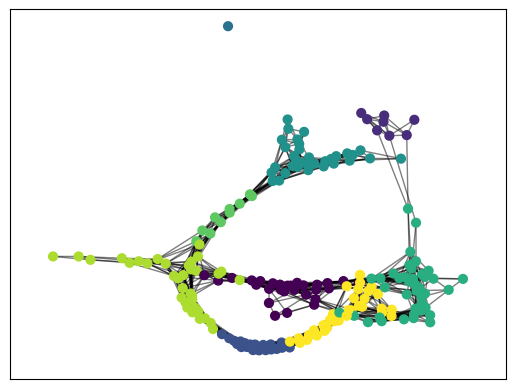

In [13]:
# compute the best partition
partition = community_louvain.best_partition(G)

# draw the graph
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

In [8]:
from collections import defaultdict

In [9]:
dd = defaultdict(list)
for key, value in partition.items():
    dd[value].append(int(key))

In [10]:
traffic_df = data_df.pivot(columns='entity_id', values='traffic_speed', index='time')
traffic_df.replace(0, traffic_df.mean(), inplace=True)

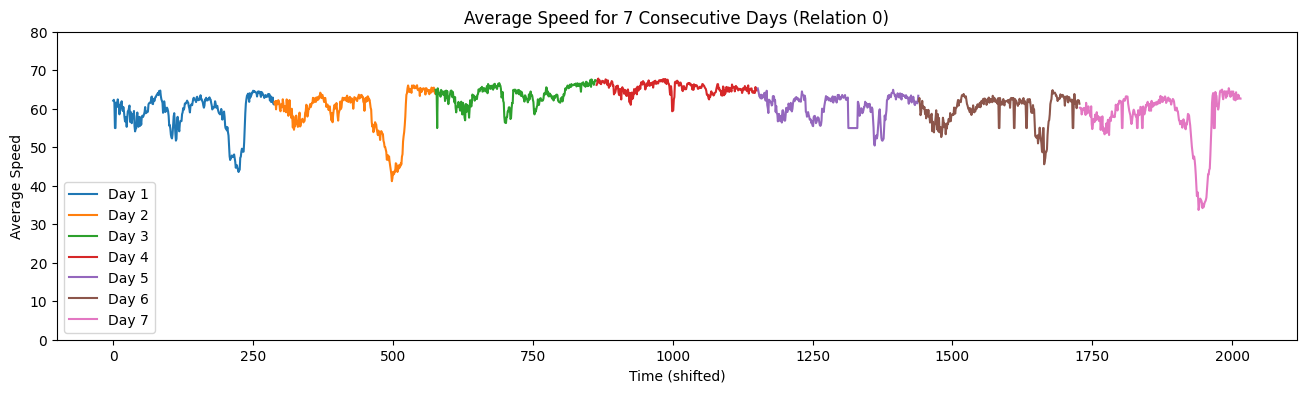

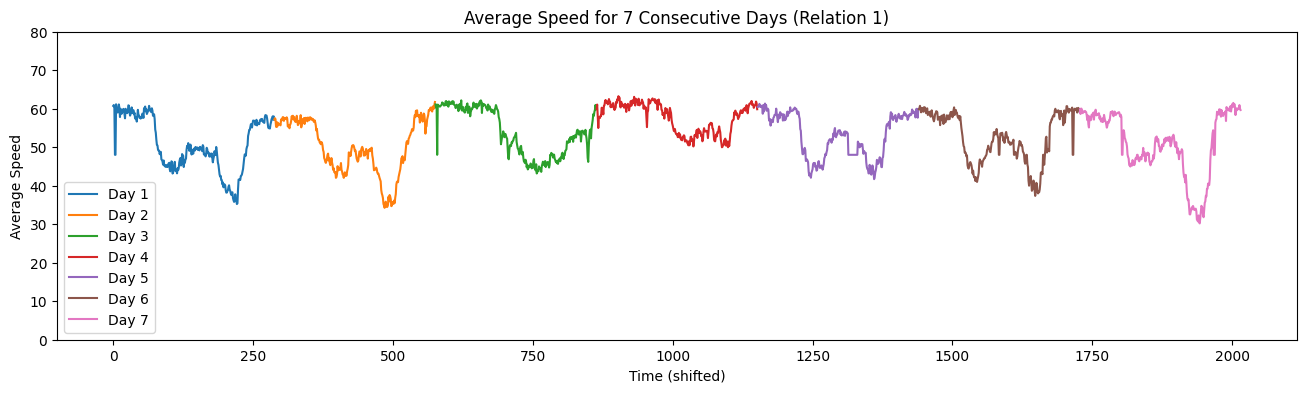

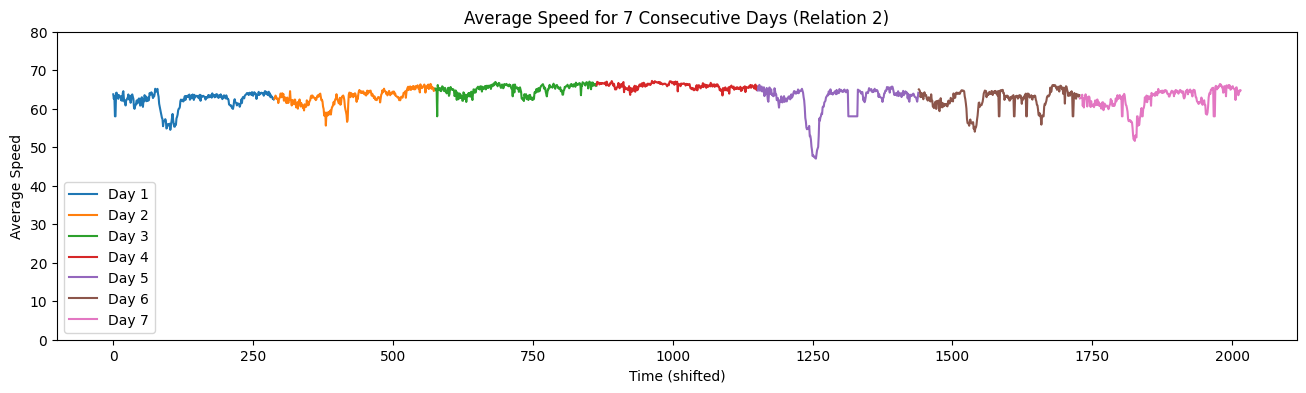

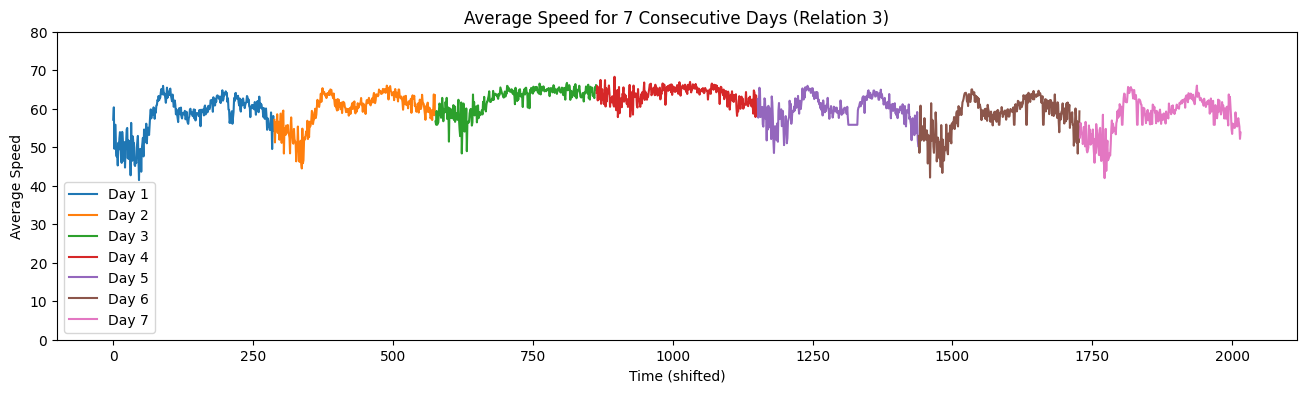

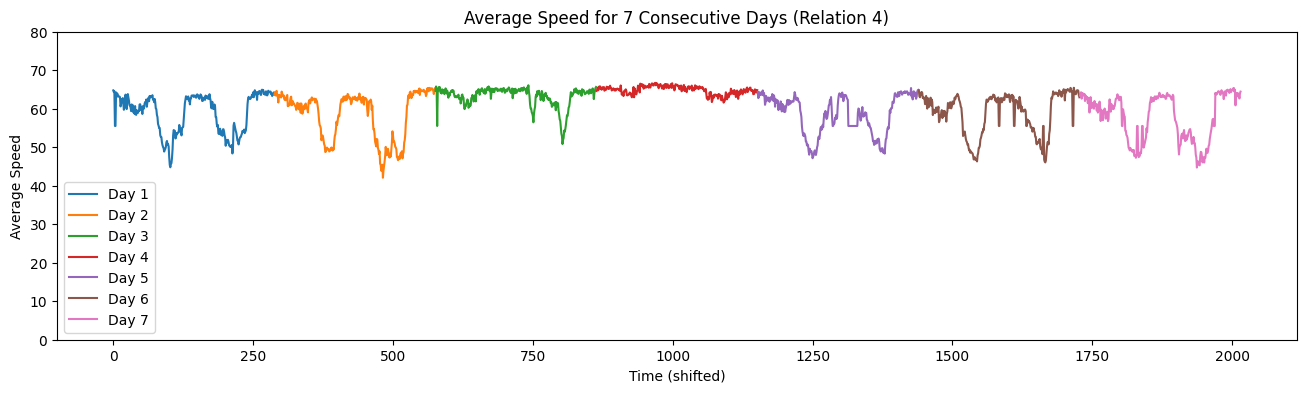

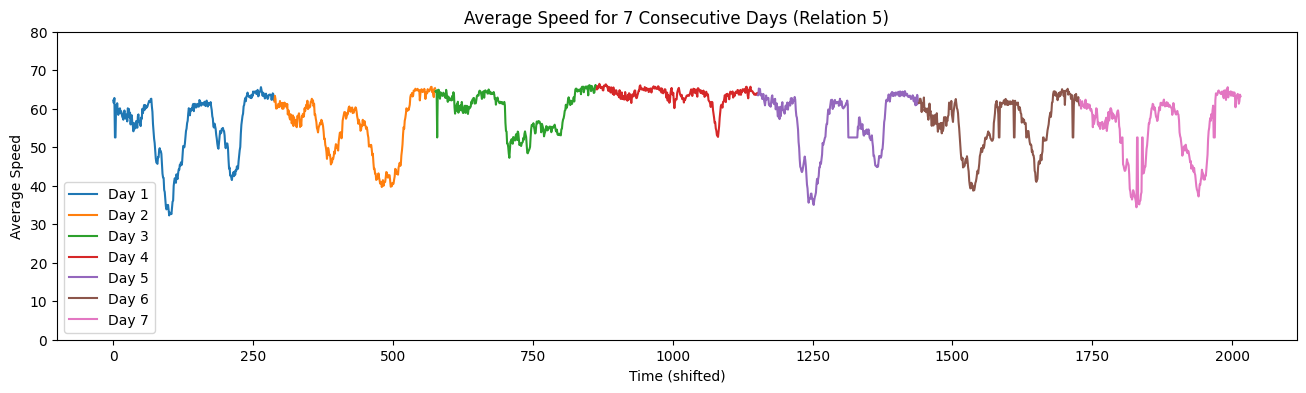

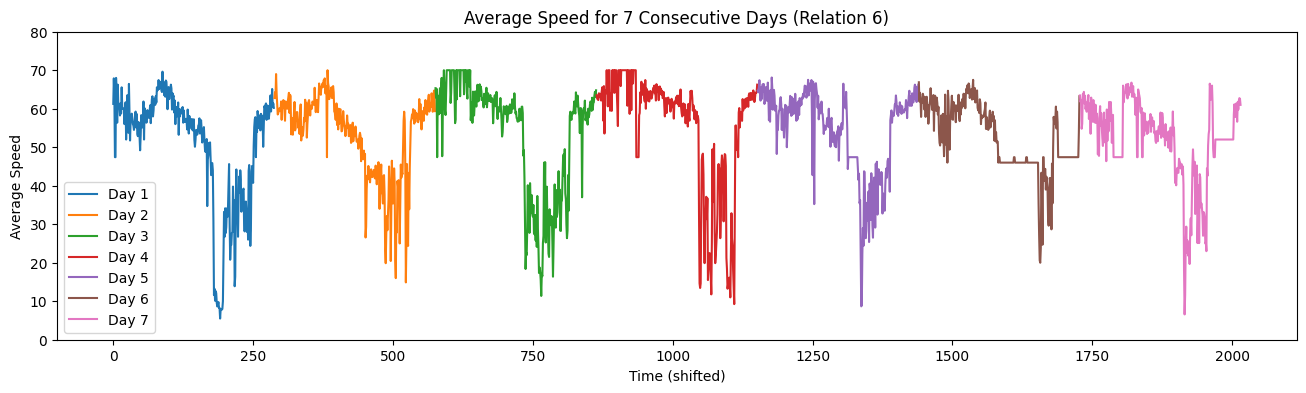

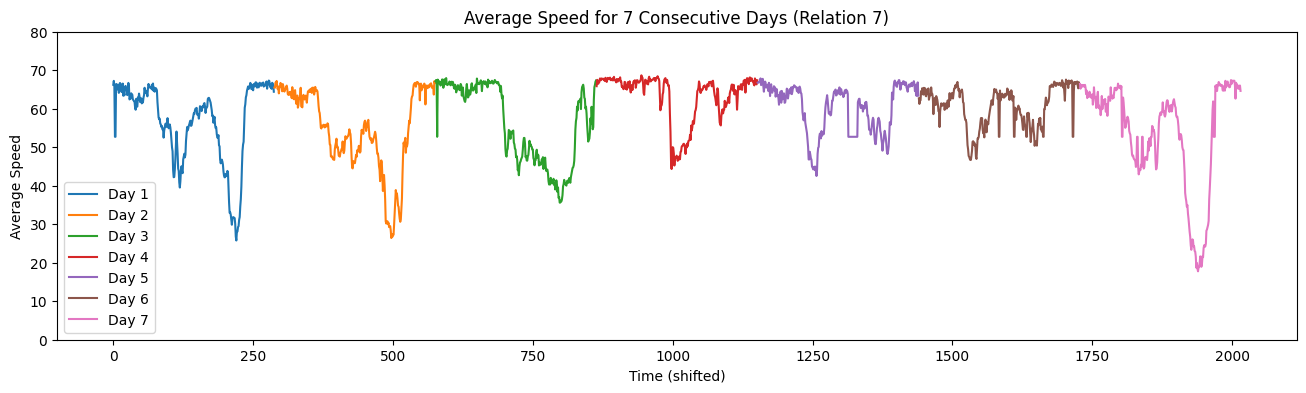

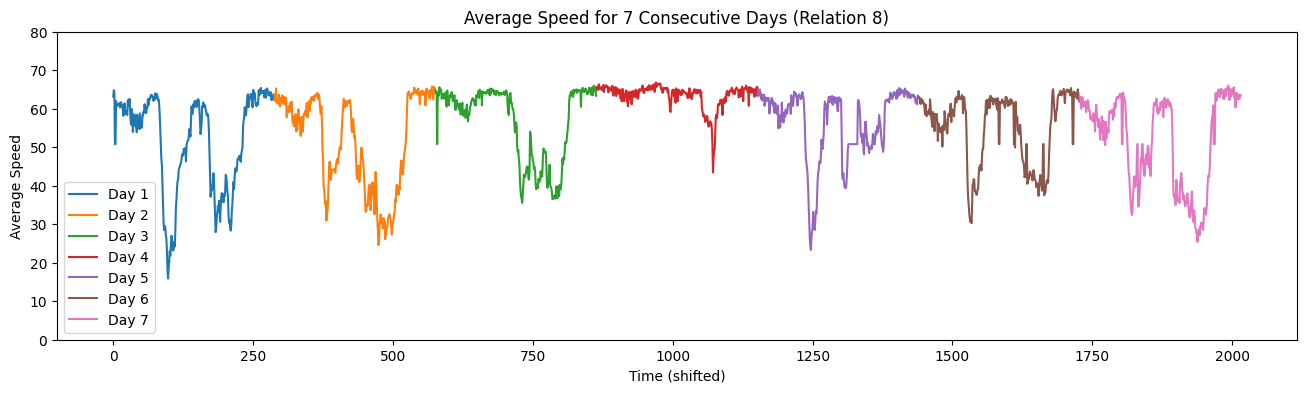

In [11]:
import matplotlib.pyplot as plt

# Параметры
slice = 24 * 60 // 5  # Количество интервалов за 1 день (при 5-минутном шаге)
days = 7              # Количество дней
relations = len(dd.keys())  # Количество групп узлов

for relation in range(relations):
    # Создаем график, на котором будут отображаться все 7 дней последовательно
    plt.figure(figsize=(16, 4))
    
    for day in range(days):
        start = slice * day
        end = slice * (day + 1)
        
        # Сдвигаем индекс, чтобы отобразить дни последовательно
        daily_mean = traffic_df[dd[relation]].mean(axis=1)[start:end]
        
        # Задаем ось x, чтобы временные метки не пересекались
        daily_mean.index = range(start, end)
        
        # Рисуем график для каждого дня
        daily_mean.plot(label=f'Day {day + 1}')
    
    # Настройка графика
    plt.ylim(0, 80)
    plt.xlabel("Time (shifted)")
    plt.ylabel("Average Speed")
    plt.title(f"Average Speed for 7 Consecutive Days (Relation {relation})")
    plt.legend()
    plt.show()


In [12]:
import os
import numpy as np
import pandas as pd

# Папка, куда будем сохранять файлы
output_folder = "T-GCN/T-GCN/T-GCN-PyTorch/data/"
os.makedirs(output_folder, exist_ok=True)  # Создаем папку, если ее еще нет


# Количество подграфов
lens = len(dd.keys())

# Проходим по каждому ключу в `dd`
for i in range(lens):
    # 1. Создаем подграф и матрицу смежности с единичной диагональю
    subG = G.subgraph([str(x) for x in dd[i]])
    subdf = pd.DataFrame(nx.to_numpy_array(subG, weight='weight')) + np.eye(len(dd[i]))
    subdf.columns = dd[i]
    
    # 2. Извлекаем соответствующую часть DataFrame для подграфа
    subtraffic = traffic_df[dd[i]][:2016]
    
    # 3. Сохраняем матрицу смежности в CSV
    subdf_path = os.path.join(output_folder, f"subgraph_matrix_{i}.csv")
    subdf.to_csv(subdf_path, index=False, header=False)
    
    # 4. Сохраняем часть traffic_df в отдельный CSV
    subtraffic_path = os.path.join(output_folder, f"subtraffic_{i}.csv")
    subtraffic.to_csv(subtraffic_path, index=False)
    
    print(f"Сохранены файлы для подграфа {i}:")
    print(f"- Матрица смежности: {subdf_path}")
    print(f"- Данные трафика: {subtraffic_path}")

Сохранены файлы для подграфа 0:
- Матрица смежности: T-GCN/T-GCN/T-GCN-PyTorch/data/subgraph_matrix_0.csv
- Данные трафика: T-GCN/T-GCN/T-GCN-PyTorch/data/subtraffic_0.csv
Сохранены файлы для подграфа 1:
- Матрица смежности: T-GCN/T-GCN/T-GCN-PyTorch/data/subgraph_matrix_1.csv
- Данные трафика: T-GCN/T-GCN/T-GCN-PyTorch/data/subtraffic_1.csv
Сохранены файлы для подграфа 2:
- Матрица смежности: T-GCN/T-GCN/T-GCN-PyTorch/data/subgraph_matrix_2.csv
- Данные трафика: T-GCN/T-GCN/T-GCN-PyTorch/data/subtraffic_2.csv
Сохранены файлы для подграфа 3:
- Матрица смежности: T-GCN/T-GCN/T-GCN-PyTorch/data/subgraph_matrix_3.csv
- Данные трафика: T-GCN/T-GCN/T-GCN-PyTorch/data/subtraffic_3.csv
Сохранены файлы для подграфа 4:
- Матрица смежности: T-GCN/T-GCN/T-GCN-PyTorch/data/subgraph_matrix_4.csv
- Данные трафика: T-GCN/T-GCN/T-GCN-PyTorch/data/subtraffic_4.csv
Сохранены файлы для подграфа 5:
- Матрица смежности: T-GCN/T-GCN/T-GCN-PyTorch/data/subgraph_matrix_5.csv
- Данные трафика: T-GCN/T-GCN/T-GC

## Пробую преобразовать данные перед передачей в модель

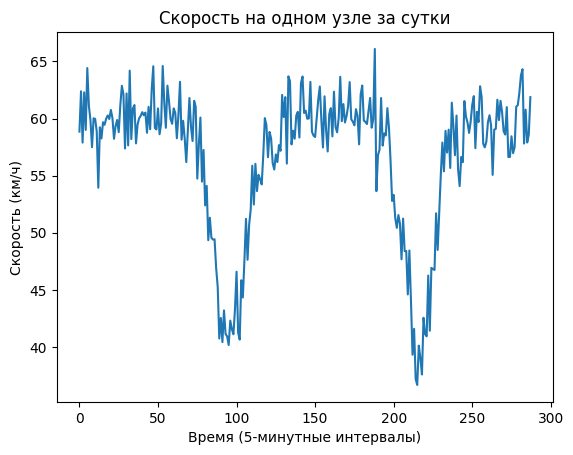

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Генерация данных
time_steps = 288
base_speed = 60  # Средняя скорость
rush_hour_effect = lambda t: 20 * np.exp(-0.5 * ((t - 96) / 10)**2) + 20 * np.exp(-0.5 * ((t - 216) / 10)**2)  # Пики
speeds = base_speed - rush_hour_effect(np.arange(time_steps)) + np.random.normal(0, 2, time_steps)

# Визуализация
plt.plot(speeds)
plt.title("Скорость на одном узле за сутки")
plt.xlabel("Время (5-минутные интервалы)")
plt.ylabel("Скорость (км/ч)")
plt.show()


In [2]:
from sklearn.model_selection import train_test_split

# Параметры окна
window_size = 12
X = np.array([speeds[i:i+window_size] for i in range(len(speeds) - window_size)])
Y = speeds[window_size:]

# Разделение на обучение и тест
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [3]:
mean, std = X_train.mean(), X_train.std()
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std
Y_train = (Y_train - mean) / std
Y_test = (Y_test - mean) / std


In [4]:
import torch
edge_index = torch.tensor([[0, 1, 2], [1, 2, 0]], dtype=torch.long)  # Связи
edge_weights = torch.tensor([0.5, 0.8, 0.3], dtype=torch.float)  # Веса рёбер

In [5]:
from statsmodels.tsa.seasonal import STL

stl = STL(speeds, period=288)  # Периодичность = 1 сутки (288 интервалов)
result = stl.fit()
trend = result.trend
seasonal = result.seasonal
residual = result.resid


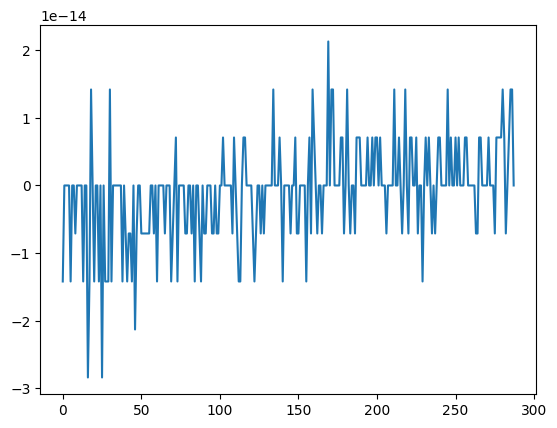

In [16]:
plt.plot(residual)
# plt.ylim(56, 57)
plt.show()

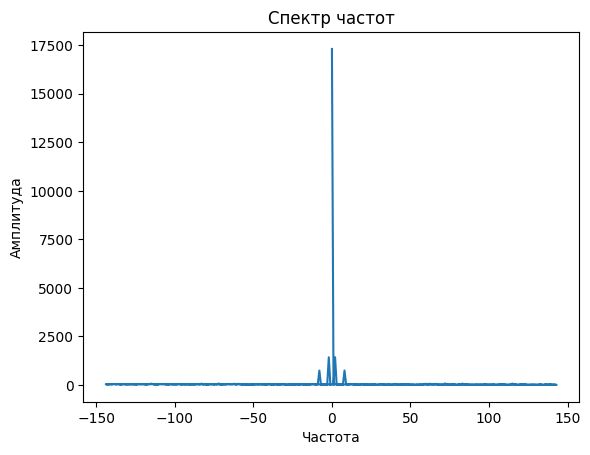

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

# Генерация данных
time_steps = 288
t = np.linspace(0, 1, time_steps)
speed = 60 + 10 * np.sin(2 * np.pi * 2 * t) + 5 * np.sin(2 * np.pi * 8 * t) + np.random.normal(0, 2, time_steps)

# Преобразование Фурье
fft_values = fft(speed)
frequencies = fftfreq(len(speed), d=1/time_steps)  # d=шаг по времени

# Визуализация спектра
plt.plot(frequencies[:time_steps], np.abs(fft_values[:time_steps]))
plt.title("Спектр частот")
plt.xlabel("Частота")
plt.ylabel("Амплитуда")
plt.show()


Значимые частоты: [ 0.  2. -2.  8. -8.]


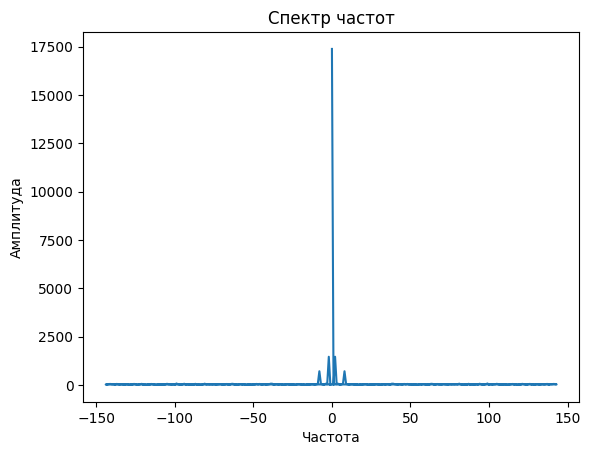

In [23]:
import numpy as np
from scipy.fft import fft, ifft, fftfreq
import matplotlib.pyplot as plt

# Симулируем данные (можно заменить на ваши реальные данные)
time_steps = 288
t = np.linspace(0, 1, time_steps)
speed = 60 + 10 * np.sin(2 * np.pi * 2 * t) + 5 * np.sin(2 * np.pi * 8 * t) + np.random.normal(0, 2, time_steps)

# Преобразование Фурье
fft_values = fft(speed)
frequencies = fftfreq(len(speed), d=1/time_steps)

# Найдём частоты с наибольшими амплитудами
amplitudes = np.abs(fft_values)
significant_indices = np.argsort(amplitudes)[::-1]  # Индексы в порядке убывания амплитуд
significant_frequencies = frequencies[significant_indices[:5]]  # 5 наиболее значимых частот
print("Значимые частоты:", significant_frequencies[:5])

# Визуализация спектра
plt.plot(frequencies[:time_steps], amplitudes[:time_steps])
plt.title("Спектр частот")
plt.xlabel("Частота")
plt.ylabel("Амплитуда")
plt.show()


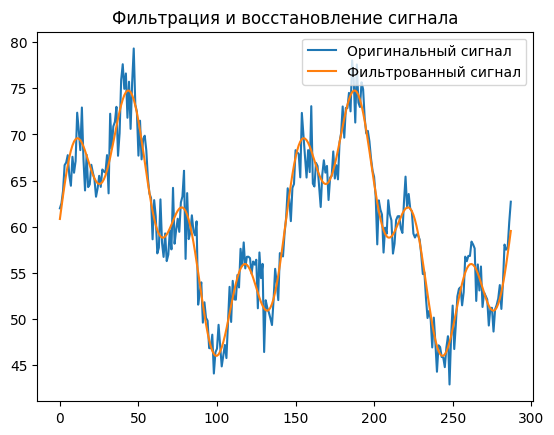

In [25]:
# Фильтруем только значимые частоты
filtered_fft = np.zeros_like(fft_values)
threshold = 500  # Порог для выбора частот
filtered_fft[amplitudes > threshold] = fft_values[amplitudes > threshold]

# Обратное преобразование
filtered_signal = ifft(filtered_fft).real

# Сравнение оригинального и сглаженного сигнала
plt.plot(speed, label="Оригинальный сигнал")
plt.plot(filtered_signal, label="Фильтрованный сигнал")
plt.legend()
plt.title("Фильтрация и восстановление сигнала")
plt.show()

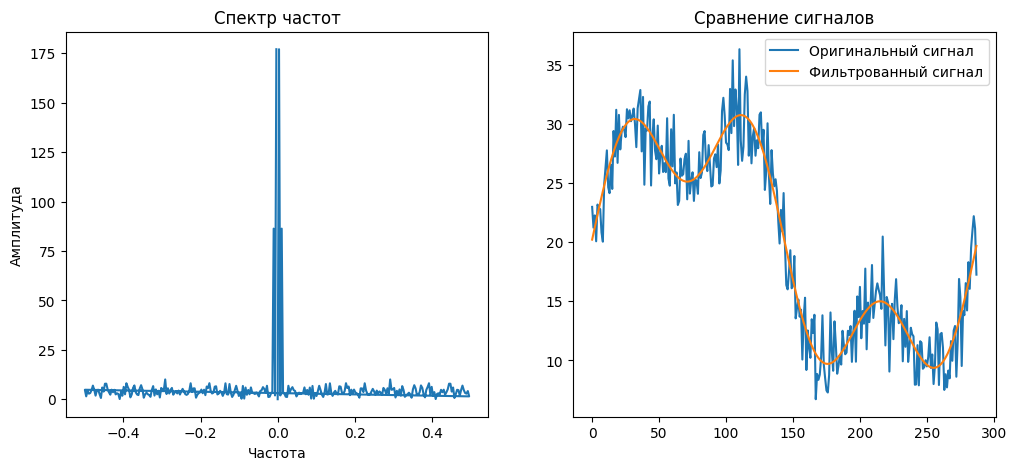

Значимые частоты: [ 0.00347222  0.01041667 -0.01041667 -0.00347222]


In [30]:
import numpy as np
from scipy.fft import fft, ifft, fftfreq
import matplotlib.pyplot as plt

def process_speed_data(speed_data, threshold_std=0.9):
    """
    Выполняет Фурье-анализ, фильтрацию шума и восстановление сигнала.

    Параметры:
        speed_data (array): Временной ряд данных скорости.
        threshold_std (float): Порог для амплитуд в единицах стандартного отклонения (z-score).

    Возвращает:
        filtered_signal (array): Восстановленный сигнал после фильтрации.
        significant_frequencies (array): Частоты с амплитудами выше порога.
    """
    # 1. Стандартизация данных
    mean, std = np.mean(speed_data), np.std(speed_data)
    standardized_data = (speed_data - mean) / std

    # 2. Преобразование Фурье
    fft_values = fft(standardized_data)
    frequencies = fftfreq(len(standardized_data), d=1)  # d=шаг времени (можно адаптировать)
    amplitudes = np.abs(fft_values)

    # 3. Порог на основе стандартного отклонения
    threshold = threshold_std * np.std(amplitudes)
    filtered_fft = np.zeros_like(fft_values)
    filtered_fft[amplitudes > threshold] = fft_values[amplitudes > threshold]

    # 4. Обратное преобразование
    filtered_signal = ifft(filtered_fft).real

    # 5. Восстановление масштаба сигнала
    filtered_signal = filtered_signal * std + mean

    # 6. Значимые частоты
    significant_frequencies = frequencies[amplitudes > threshold]

    # 7. Визуализация
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(frequencies[:len(frequencies)], amplitudes[:len(frequencies)])
    plt.title("Спектр частот")
    plt.xlabel("Частота")
    plt.ylabel("Амплитуда")

    plt.subplot(1, 2, 2)
    plt.plot(speed_data, label="Оригинальный сигнал")
    plt.plot(filtered_signal, label="Фильтрованный сигнал")
    plt.legend()
    plt.title("Сравнение сигналов")
    plt.show()

    return filtered_signal, significant_frequencies

# Пример использования
speed_data = [20 + 10 * np.sin(2 * np.pi * t / 288) + 5 * np.sin(2 * np.pi * t / 96) + np.random.normal(0, 2) for t in range(288)]
filtered_signal, significant_frequencies = process_speed_data(speed_data)
print("Значимые частоты:", significant_frequencies)